In [1]:
import FileHandler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display
from AudioMIDIAligner.PureAligner import *

all_songs = FileHandler.get_all_songs()

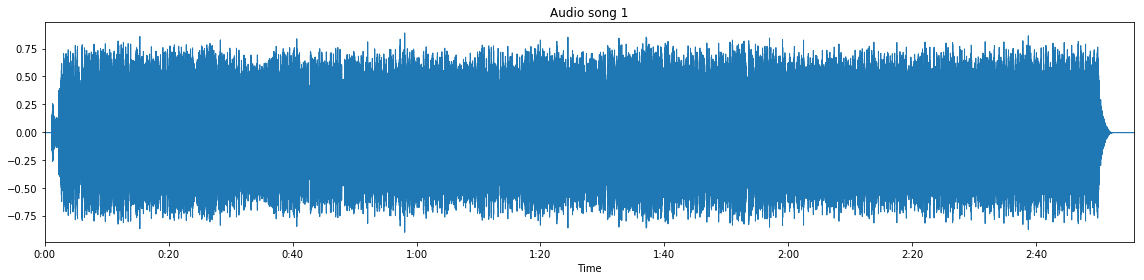

In [9]:
full_audio_path = '/media/daphne/Seagate Expansion Drive/Data/Input/Audio/1.wav'

# Open the audio file
audio_data, _ = librosa.load(full_audio_path, sr=FS)
plt.figure(figsize=(16, 4))
librosa.display.waveplot(audio_data, sr=FS)
plt.title('Audio song '  + FileHandler.get_file_name_from_full_path(full_audio_path))
plt.tight_layout()

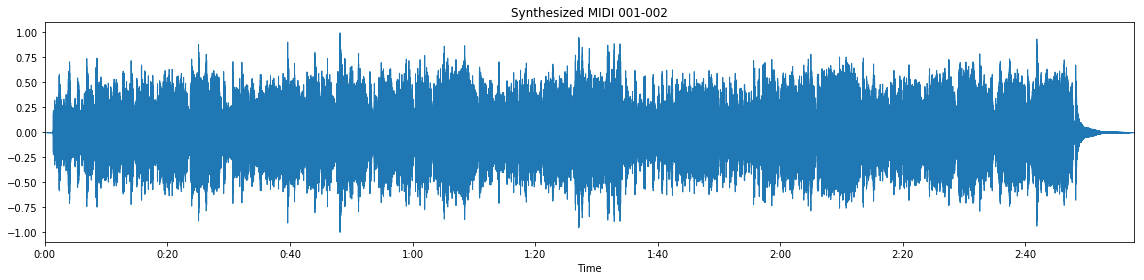

In [10]:
full_synthesized_midi_path = '/media/daphne/Seagate Expansion Drive/Data/Files/SynthMIDI/001-002.wav'

# Open the synthesized midi file
midi_audio, _ = librosa.load(full_synthesized_midi_path, sr=FS)
plt.figure(figsize=(16, 4))
librosa.display.waveplot(midi_audio, sr=FS)
plt.title('Synthesized MIDI ' + FileHandler.get_file_name_from_full_path(full_synthesized_midi_path))
plt.tight_layout()

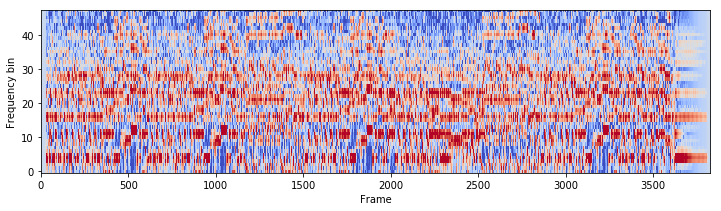

In [11]:
def display_cqt(cqt):
    """ Plot a CQT with sane defaults """
    plt.imshow(cqt.T, aspect='auto', interpolation='nearest',
               origin='lower', cmap=plt.cm.coolwarm,
               vmin=np.percentile(cqt, 5), vmax=np.percentile(cqt, 95))
    plt.xlabel('Frame')
    plt.ylabel('Frequency bin')

midi_cqt, midi_times = compute_cqt(midi_audio)
plt.figure(figsize=(12, 3))
display_cqt(midi_cqt)

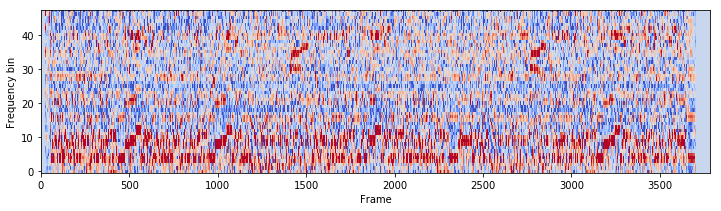

In [12]:
audio_cqt, audio_times = compute_cqt(audio_data)
plt.figure(figsize=(12, 3))
display_cqt(audio_cqt)

In [13]:
import scipy.spatial

# Compute the distance matrix of the midi and audio CQTs, using cosine distance
distance_matrix = scipy.spatial.distance.cdist(midi_cqt, audio_cqt, 'cosine')
penalty = float(np.median(np.ravel(distance_matrix)))
# Get lowest cost path in the distance matrix
p, q, score = dtw(distance_matrix, GULLY, penalty)
# Normalize by path length and the distance matrix sub-matrix within the path
score = score / len(p)
score = score / distance_matrix[p.min():p.max(), q.min():q.max()].mean()

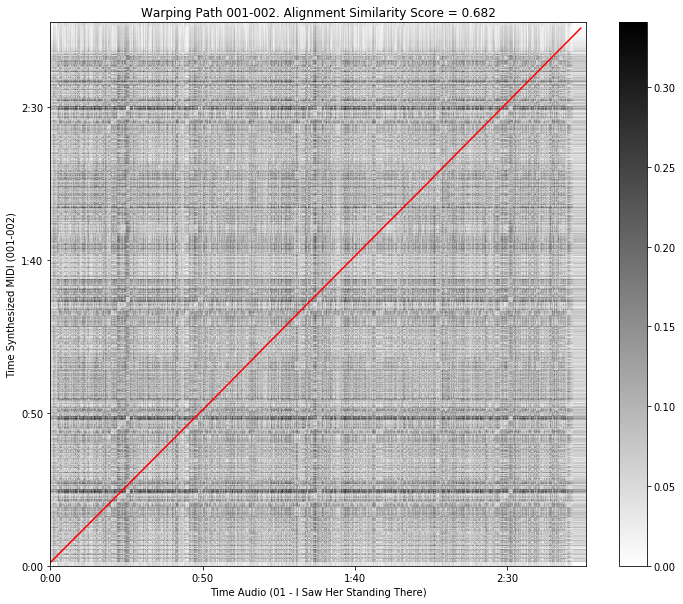

In [14]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
librosa.display.specshow(distance_matrix, x_axis='time', y_axis='time',
                         cmap=plt.get_cmap('gray_r'), hop_length=HOP_LENGTH)
imax = ax.imshow(distance_matrix, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(midi_times[p], audio_times[q], color='r')
plt.title('Warping Path ' + FileHandler.get_file_name_from_full_path(full_synthesized_midi_path) + '. Alignment Similarity Score = ' + str(round(score, 3)))

plt.xlabel('Time Audio (' + all_songs[int(FileHandler.get_file_name_from_full_path(full_audio_path))].title + ')')
plt.ylabel('Time Synthesized MIDI (' + FileHandler.get_file_name_from_full_path(full_synthesized_midi_path) + ')')
plt.colorbar()

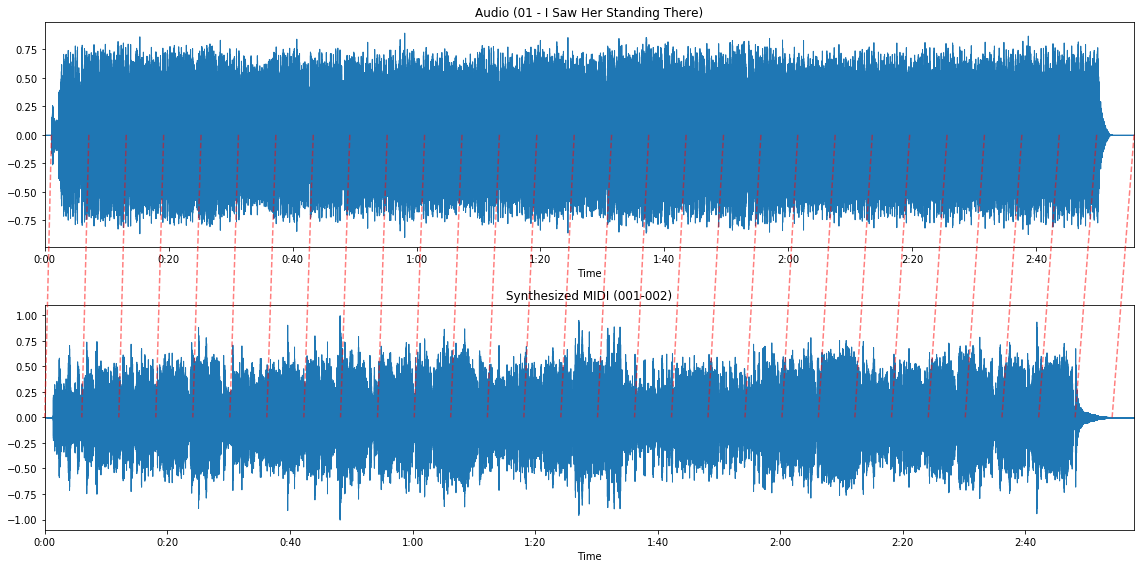

In [15]:
fig = plt.figure(figsize=(16, 8))

# Plot x_1
plt.subplot(2, 1, 1)
librosa.display.waveplot(audio_data, sr=FS)
plt.title('Audio (' + all_songs[int(FileHandler.get_file_name_from_full_path(full_audio_path))].title + ')')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveplot(midi_audio, sr=FS)
plt.title('Synthesized MIDI (' + FileHandler.get_file_name_from_full_path(full_synthesized_midi_path) + ')')
ax2 = plt.gca()

plt.tight_layout()

trans_figure = fig.transFigure.inverted()
lines = []
arrows = 30
points_idx = np.int16(np.round(np.linspace(0, len(p) - 1, arrows)))

for i in points_idx:
    tp2 = midi_times[p[i]]
    tp1 = audio_times[q[i]]
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r', alpha=0.5, linestyle='dashed')
    lines.append(line)

fig.lines = lines
plt.tight_layout()